<a href="https://colab.research.google.com/github/Pmskabir1234/Torch/blob/main/transferred_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: saadabir0108
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification


100%|██████████| 155M/155M [00:00<00:00, 1.42GB/s]

In [4]:
import torch
from torch import nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
train_df = pd.read_csv('/content/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv("/content/bean-leaf-lesions-classification/val.csv")
train_df.head(10)

,image:FILE,category
0,train/healthy/healthy_train.98.jpg,0
1,train/healthy/healthy_train.148.jpg,0
2,train/healthy/healthy_train.306.jpg,0
3,train/healthy/healthy_train.305.jpg,0
4,train/healthy/healthy_train.40.jpg,0
5,train/healthy/healthy_train.200.jpg,0
6,train/healthy/healthy_train.295.jpg,0
7,train/healthy/healthy_train.158.jpg,0
8,train/healthy/healthy_train.6.jpg,0
9,train/healthy/healthy_train.73.jpg,0


In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [7]:
base_image_path = './bean-leaf-lesions-classification/'
class CustomDataset(Dataset):
  def __init__(self, dataframe, transform, root_dir):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe['category']).to(device)
    self.root_dir = root_dir

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_name = self.dataframe.loc[idx, 'image:FILE']
    img_path = os.path.join(self.root_dir, img_name)
    label = self.labels[idx]
    image = Image.open(img_path).convert("RGB")
    if self.transform:
      image = (self.transform(image)/255.0).to(device)
    return image, label

In [8]:
train_dataset = CustomDataset(train_df, transform, base_image_path)
val_dataset = CustomDataset(val_df, transform, base_image_path)

Let's take a look into image data that we have

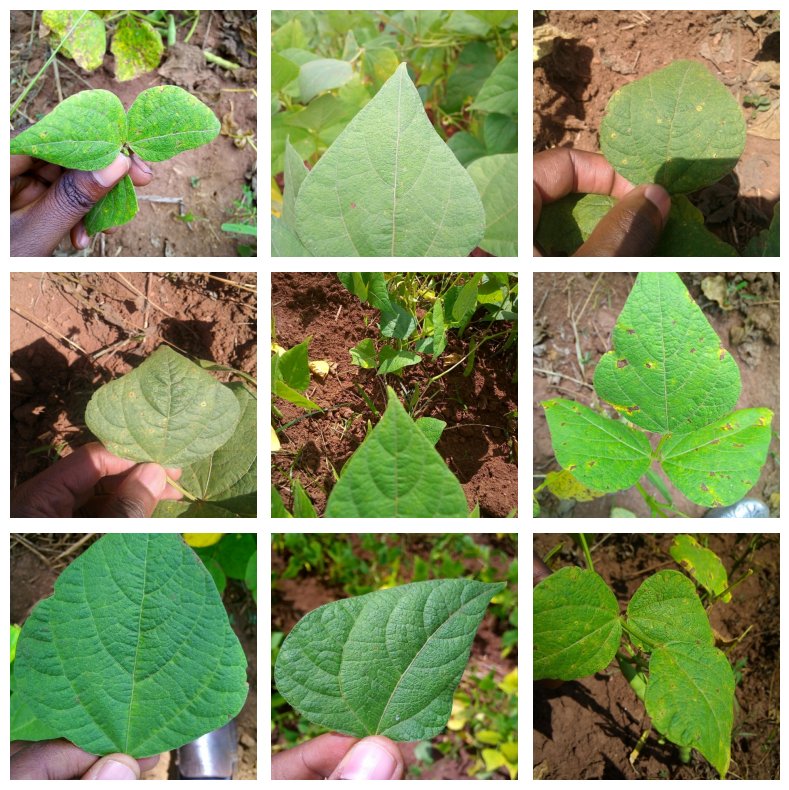

In [9]:
import random
n_rows = 3
n_cols = 3
f,axarr = plt.subplots(n_rows, n_cols, figsize=(8, 8))

for row in range(n_rows):
  for col in range(n_cols):
    idx = random.randint(0,val_df.shape[0] - 1)
    relative_image_path = val_df.loc[idx,'image:FILE']
    full_image_path = os.path.join(base_image_path, relative_image_path)
    image = Image.open(full_image_path).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.tight_layout()
plt.show()

In [10]:
train_data = DataLoader(train_dataset,batch_size=16, shuffle=True)
val_data = DataLoader(val_dataset,batch_size = 16, shuffle=True)

In [11]:
LR = 1e-3
EPOCHS = 15

Now, for the classification task we will use a pretrained model called "googlenet". We can access it from the 'models' library of 'torchvision' module.

In [12]:
googlenet_model = models.googlenet(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:01<00:00, 37.5MB/s]


now we don't want the model to set the parameters randomly and learn gradually, instead we will tell the model to initiate the parameters from the previous knowlwdge. The will update the weights from the new hidden layers as we will train it on our data.  

In [16]:
for param in googlenet_model.parameters():
  param.requires_grad = True

"""   By setting 'requires_grad = True' for all parameters,
      you allow the model to adjust all its weights based on your specific data,
      even if it was pre-trained on a different dataset.
      This is a common approach when your dataset is large enough and similar to the pre-training data.
"""

"   By setting 'requires_grad = True' for all parameters,\n      you allow the model to adjust all its weights based on your specific data,\n      even if it was pre-trained on a different dataset.\n      This is a common approach when your dataset is large enough and similar to the pre-training data.\n"

In [15]:
#now will take a look into the last layer of the model
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

as we can see the last layer is a linear layer that has 1000 out_features. But in our case, we have only 3 classes. So we will change the architecture according to our requirement.

In [14]:
num_classes = len(train_df['category'].unique())
num_classes

3

In [14]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [17]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),lr=LR)

In [17]:
total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0
  for inputs,labels in train_data:

    optimizer.zero_grad()
    output = googlenet_model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0476    Total Acc : 67.9884%
Epoch : 2    Total Loss : 0.0352    Total Acc : 77.6596%
Epoch : 3    Total Loss : 0.0291    Total Acc : 81.7215%
Epoch : 4    Total Loss : 0.0243    Total Acc : 84.913%
Epoch : 5    Total Loss : 0.0247    Total Acc : 85.1064%
Epoch : 6    Total Loss : 0.0204    Total Acc : 87.7176%
Epoch : 7    Total Loss : 0.0166    Total Acc : 89.5551%
Epoch : 8    Total Loss : 0.0177    Total Acc : 89.0716%
Epoch : 9    Total Loss : 0.0144    Total Acc : 91.9729%
Epoch : 10    Total Loss : 0.0156    Total Acc : 91.8762%
Epoch : 11    Total Loss : 0.0139    Total Acc : 91.8762%
Epoch : 12    Total Loss : 0.0174    Total Acc : 89.6518%
Epoch : 13    Total Loss : 0.0127    Total Acc : 93.617%
Epoch : 14    Total Loss : 0.0119    Total Acc : 93.617%
Epoch : 15    Total Loss : 0.0107    Total Acc : 93.7137%


Text(0.5, 1.0, 'Accuracy')

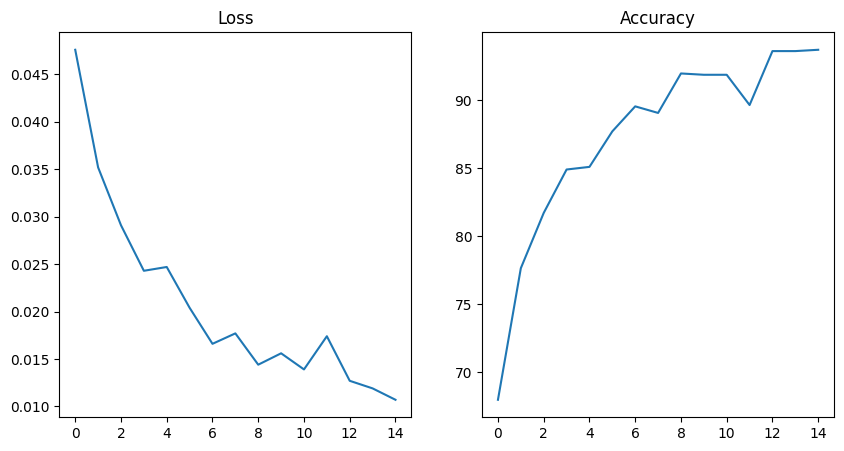

In [18]:
f, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].plot(total_train_loss_plot, label="Loss")
axs[0].set_title("Loss")


axs[1].plot(total_train_acc_plot, label="Accuracy")
axs[1].set_title("Accuracy")


In [19]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0

  for inputs,labels in val_data:
    outputs = googlenet_model(inputs)

    acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_test_acc += acc

In [20]:
print(f'Total test accuracy: {round(total_test_acc/val_dataset.__len__()*100, 4)}%')

Total test accuracy: 85.7143%


##Transfer Learning
here we will change the architecture such a way that, we won't change/update all the weights during backprop of the model, we will only change/update the weights of the last layer.

In [20]:
gnet_model = models.googlenet(weights='DEFAULT')

for param in gnet_model.parameters():
  param.requires_grad = False

gnet_model.fc = torch.nn.Linear(gnet_model.fc.in_features, num_classes)
gnet_model.fc.requires_grad = True
gnet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [22]:
total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0
  for inputs,labels in train_data:

    optimizer.zero_grad()
    output = gnet_model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0721    Total Acc : 35.6867%
Epoch : 2    Total Loss : 0.072    Total Acc : 35.6867%
Epoch : 3    Total Loss : 0.072    Total Acc : 36.7505%
Epoch : 4    Total Loss : 0.0726    Total Acc : 33.6557%
Epoch : 5    Total Loss : 0.0724    Total Acc : 35.2998%
Epoch : 6    Total Loss : 0.0722    Total Acc : 35.5899%
Epoch : 7    Total Loss : 0.0724    Total Acc : 33.8491%
Epoch : 8    Total Loss : 0.0723    Total Acc : 34.4294%
Epoch : 9    Total Loss : 0.0724    Total Acc : 35.0097%
Epoch : 10    Total Loss : 0.0723    Total Acc : 35.6867%
Epoch : 11    Total Loss : 0.0724    Total Acc : 35.0097%
Epoch : 12    Total Loss : 0.0719    Total Acc : 34.7195%
Epoch : 13    Total Loss : 0.072    Total Acc : 35.7834%
Epoch : 14    Total Loss : 0.0723    Total Acc : 36.4603%
Epoch : 15    Total Loss : 0.0725    Total Acc : 34.1393%


In [23]:
with torch.no_grad():
  total_test_loss = 0
  total_test_acc = 0

  for inputs,labels in val_data:
    outputs = gnet_model(inputs)

    acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_test_acc += acc

print(f"Test Accuracy: {round(total_test_acc/val_dataset.__len__()*100, 4)}%")

Test Accuracy: 36.0902%


##Customizing an existing model
here we will add layers according to our choice, to experiment with the model so that we get better accuracy

In [21]:
class CustomGoogleNet(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.backbone = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits = True)
    in_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Identity()

    self.classifier = nn.Sequential(
        nn.Linear(in_features,512),
        nn.BatchNorm1d(512),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128,num_classes)
    )

  def forward(self,x):
    outputs = self.backbone(x)
    if isinstance(outputs,tuple) or hasattr(outputs,"logits"):
      x = outputs.logits
    else:
      x = outputs

    x = self.classifier(x)
    return x


In [22]:
model = CustomGoogleNet(num_classes).to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


In [23]:
total_train_loss_plot = []
total_train_acc_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0
  total_train_acc = 0

  for inputs,labels in train_data:
    optimizer.zero_grad()
    output = model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0718    Total Acc : 31.0445%


KeyboardInterrupt: 

##Two-Phase Training (Transfer Learning) — Workflow & Essence
Two-phase training is a controlled fine-tuning strategy used in transfer learning where a pretrained model is adapted to a new task gradually, instead of training all layers at once.

The idea is simple: "First learn to read pretrained features, then slightly adjust those features to your task."

###Why Two-Phase Training is Needed

Pretrained models (like GoogLeNet) are trained on large datasets (e.g., ImageNet).
Directly training all layers on a smaller or different dataset can:

1.destroy pretrained knowledge (catastrophic forgetting)

2.cause unstable gradients

3.lead to overfitting

Two-phase training balances stability and adaptability.

###Overall Workflow
Pretrained Backbone
        ↓

Phase 1: Freeze Backbone → Train Classifier Head
        ↓

Phase 2: Unfreeze Late Layers → Fine-Tune with Low LR
        ↓

Task-specific Optimized Model

## Phase 1 — Warm-Up Training (Feature Utilization)
🔹 What Happens

Backbone (pretrained CNN): Frozen

Classifier head (new layers): Trainable

Only the final layers learn

🔹 Purpose

Allow the classifier to understand pretrained feature representations

Prevent random gradients from damaging pretrained weights

🔹 Characteristics

Fast convergence

Stable training

No modification of backbone features

🔹 Typical Setup

Learning Rate: High (e.g., 1e-3)

Epochs: 5–10

Trainable parameters: classifier only

##Phase 2 — Fine-Tuning (Feature Adaptation)
🔹 What Happens

Early layers: remain frozen

Late layers: unfrozen

Classifier: still trainable

🔹 Purpose

Adapt high-level features to the new dataset

Improve performance when pretrained features don’t fully match the task

🔹 Characteristics

Slower learning

Small weight updates

Higher generalization capability

🔹 Typical Setup

Classifier LR: 1e-3

Backbone LR: 1e-5 or 1e-6

Epochs: 5–15

Trainable parameters: classifier + late backbone layers

##Essence of Two-Phase Training

Phase 1 learns how to use features

Phase 2 learns how to adapt features

Training is stable, controlled, and efficient

Prevents catastrophic forgetting

Improves generalization on small/medium datasets

In [31]:
def freeze_bn(model):
  for m in model.modules():
    if isinstance(m,nn.BatchNorm2d):
      m.eval()



In [32]:
for p in model.backbone.parameters():
  p.requires_grad = False

freeze_bn(model)

optimizer = Adam(model.classifier.parameters(), lr = 1e-3)

In [33]:
EPOCHS1 = 5

for epoch in range(EPOCHS1):
  model.train()
  total_train_loss = 0
  total_train_acc = 0

  for inputs,labels in train_data:
    optimizer.zero_grad()
    output = model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0586    Total Acc : 58.3172%
Epoch : 2    Total Loss : 0.0482    Total Acc : 68.6654%
Epoch : 3    Total Loss : 0.0469    Total Acc : 70.1161%
Epoch : 4    Total Loss : 0.0432    Total Acc : 70.5029%
Epoch : 5    Total Loss : 0.0414    Total Acc : 73.5977%


In [34]:
for name,p in model.backbone.named_parameters():
  if 'inception4' in name or 'inception5'in name:
    p.requires_grad = True

freeze_bn(model)

optimizer = Adam([
    {'params':model.classifier.parameters(), "lr":1e-3},
    {'params':model.backbone.parameters(), "lr":1e-5},
])

In [35]:
EPOCHS2 = 10

for epoch in range(EPOCHS2):
  model.train()
  total_train_loss = 0
  total_train_acc = 0

  for inputs,labels in train_data:
    optimizer.zero_grad()
    output = model(inputs)
    train_loss = criterion(output, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(output, axis=1) == labels).sum().item()
    total_train_acc += train_acc
    optimizer.step()

  total_train_loss_plot.append(round(total_train_loss/1000, 4))
  total_train_acc_plot.append(round(total_train_acc/train_dataset.__len__()*100, 4))

  print(f"Epoch : {epoch+1}    Total Loss : {round(total_train_loss/1000, 4)}    Total Acc : {round(total_train_acc/train_dataset.__len__()*100, 4)}%")

Epoch : 1    Total Loss : 0.0399    Total Acc : 73.6944%
Epoch : 2    Total Loss : 0.0316    Total Acc : 78.9168%
Epoch : 3    Total Loss : 0.0271    Total Acc : 84.1393%
Epoch : 4    Total Loss : 0.0255    Total Acc : 84.4294%
Epoch : 5    Total Loss : 0.0202    Total Acc : 87.911%
Epoch : 6    Total Loss : 0.017    Total Acc : 89.7485%
Epoch : 7    Total Loss : 0.0133    Total Acc : 92.1663%
Epoch : 8    Total Loss : 0.0136    Total Acc : 92.1663%
Epoch : 9    Total Loss : 0.0118    Total Acc : 93.617%
Epoch : 10    Total Loss : 0.009    Total Acc : 94.1006%


###Wrap-up
1. During the first training, we only preserved the model architecture, and updated all the parameters to learn from our own dataset.
2. During the second case, we preserved the model's architecture as well as the pre-trained knowledge as well. So, the outcome we have seen is worse since we did not add any extra layer, it would have help the model to optimize the paramters during training.

The pretrained models features does not match our task, that's why we got less accuracy in result. And freezing is tool, not a rule, so it's useful when we have enough large dataset.

The two phase training is not about speed, it's about control.
####When NOT to Use Two-Phase Training:

Very large dataset (train end-to-end)

Dataset extremely similar to ImageNet

Training from scratch (no pretrained weights)

###Remember:
Batch Normalization Handling

When backbone is frozen:

BatchNorm layers should remain in eval() mode

Prevents corruption of pretrained statistics